In [2]:
!nvidia-smi

Mon Feb  1 16:50:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:18:00.0 Off |                  N/A |
| 70%   80C    P2    99W / 250W |  10809MiB / 11178MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
|  0%   

In [3]:
# from models import Encoder, Decoder, Img2Caption
from dataset import CocoDataset

In [3]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

from pycocotools.coco import COCO
from nltk.translate.bleu_score import sentence_bleu

import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

from transformers import DebertaTokenizer, DebertaModel

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
torch.cuda.empty_cache()

In [6]:
# training images
len(os.listdir("images_train/"))

14117

In [7]:
# val images
len(os.listdir("images_val/"))

8376

In [6]:
# current dir
os.listdir()

['.idea',
 '.ipynb_checkpoints',
 'annotations',
 'best_val_model.pt',
 'dataset.py',
 'dump_1.pt',
 'images_train',
 'images_val',
 'kot.jpg',
 'models.py',
 'Training.ipynb',
 'Usage example.ipynb',
 '__pycache__']

In [8]:
# coco = COCO(annotation_file="annotations/captions_train2014.json")
# coco.download("images_train", imgIds=[coco.anns[key]['image_id'] for key in coco.anns])

In [9]:
# coco = COCO(annotation_file="annotations/captions_val2014.json")
# coco.download("images_val", imgIds=[coco.anns[key]['image_id'] for key in coco.anns])

In [10]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

In [11]:
device = "cuda"

In [12]:
def collate_fn(data):
    images, captions = zip(*data)

    images = torch.stack(images, 0)
    max_len = max([len(caption) for caption in captions])
    targets = torch.zeros(len(captions), max_len).long()
    for i, caption in enumerate(captions):
        for j in range(len(caption)):
            targets[i, j] = caption[j]
  
    return images.to(device), targets.to(device)

In [13]:
batch_size = 16
train_data = CocoDataset("images_train/", "annotations/captions_train2014.json", tokenizer)
test_data = CocoDataset("images_val/", "annotations/captions_val2014.json", tokenizer)

train_loader = DataLoader(train_data, 
                          batch_size=batch_size, 
                          collate_fn=collate_fn)
test_loader = DataLoader(test_data, 
                          batch_size=batch_size, 
                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [14]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, encoder_dim, attention_dim, hidden_size, dropout):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        self.attention_dim = attention_dim
        self.vocab_size = vocab_size

        self.attention = nn.Linear(encoder_dim+embedding_dim, attention_dim)

        self.rnn = nn.GRU(attention_dim, hidden_size) 

        self.out = nn.Linear(hidden_size+attention_dim, vocab_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, hidden, encoder_outputs):
        concated_inputs = torch.cat((inputs, encoder_outputs.unsqueeze(1)), dim=2)
        attented = self.dropout(torch.tanh(self.attention(concated_inputs))).permute(1, 0, 2)

        output, hidden = self.rnn(attented, hidden)
        concated_outputs = F.relu(torch.cat((output, attented), dim=2))
        out = self.out(self.dropout(concated_outputs))

        return out, hidden

    def initHidden(self, bs):
        return torch.zeros(1, bs, self.hidden_size, device=device)

In [15]:
class Img2Caption(nn.Module):
    def __init__(self, encoder, decoder, gptModel):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.gpt = gptModel
        
    def forward(self, image, caption, teacher_forcing_ratio=0.5):
#         caption: bs х max_len
        batch_size = caption.shape[0]
        max_len = caption.shape[1]
        trg_vocab_size = self.decoder.vocab_size
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size)
        encoder_outputs = self.encoder(image)
        caption = gptModel(caption).last_hidden_state
        
        first_input = caption[:, 0].unsqueeze(1)
        hidden = decoder.initHidden(first_input.shape[0])

        for t in range(1, max_len):
            output, hidden = self.decoder(first_input, hidden, encoder_outputs)
            outputs[t] = output

            teacher_force = np.random.random() < teacher_forcing_ratio
            if teacher_force:
                first_input = caption[:, t].unsqueeze(1)
            else:    
                first_input = self.gpt(torch.argmax(output, dim=2)).last_hidden_state.permute(1, 0, 2)
         
        return outputs

In [16]:
encoder_dim = 512
model_conv=torchvision.models.resnet101(pretrained=True)
model_conv.fc = nn.Linear(in_features=2048, out_features=encoder_dim)

for i, pair in enumerate(model_conv.named_children()):
    _, child = pair
    if len(list((model_conv.named_children()))) - i > 3:
        for _, params in child.named_parameters():
            params.requires_grad = False
model_conv = model_conv.to(device)       

In [17]:
# vocab_size, embedding_dim, encoder_dim, attention_dim, hidden_size, decoder_dim, dropout
decoder = Decoder(tokenizer.vocab_size, 768, encoder_dim, 256, 256, 0.2).to(device)
gptModel = DebertaModel.from_pretrained('microsoft/deberta-base').to(device)

model = Img2Caption(model_conv, decoder, gptModel).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['deberta.embeddings.position_embeddings.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
def decode_captions(captions):
    value = tokenizer.decode(captions)
    print(value)
    return value

def calculate_bleu(captions, targets):
    captions = torch.argmax(captions.permute(1, 0, 2), axis=2)
    cum_bleu = 0
    for i in range(len(captions)):
        cum_bleu += sentence_bleu(
        [decode_captions(targets[i]).split()],
         decode_captions(captions[i]).split()  
        )
    print(cum_bleu)
    return cum_bleu / len(captions)

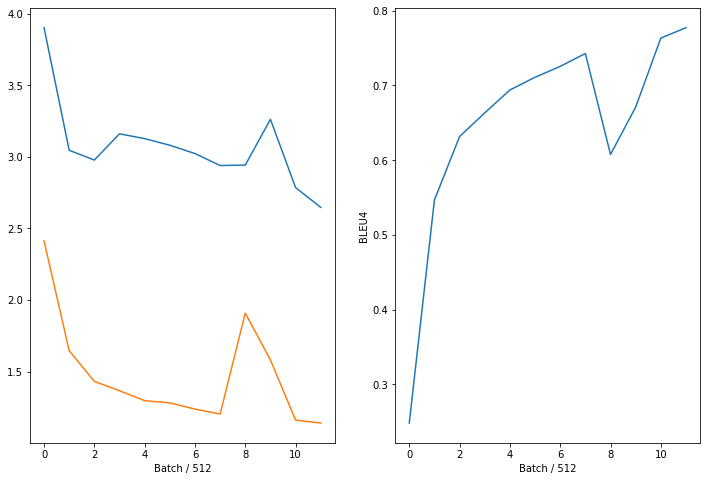

In [ ]:
%matplotlib inline
model.train()
torch.cuda.empty_cache()

logging_freq = 512


max_loss = np.inf

train_loss_accum = 0
history = []
val_bleu_history = []
val_loss_history = []
for epoch in range(20):
    for i, batch in enumerate(tqdm.notebook.tqdm(train_loader)):

        images, captions = batch

        optimizer.zero_grad()
        output = model(images, captions, teacher_forcing_ratio=1/np.log(2+epoch))
        loss = criterion(output.permute(1, 0, 2).reshape(-1, tokenizer.vocab_size).cpu(), captions.view(-1).cpu())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()
        train_loss_accum += loss 
        if (i+1)%logging_freq==0:
            history.append(train_loss_accum / logging_freq)
            train_loss_accum = 0 

            loss_accum = 0
            bleu_accum = 0
            for test_batch in tqdm.notebook.tqdm(test_loader):
                images, captions = test_batch
                output = model(images, captions, teacher_forcing_ratio=1)
                test_loss = criterion(output.permute(1, 0, 2).reshape(-1, tokenizer.vocab_size).cpu(), captions.view(-1).cpu())
                loss_accum += test_loss.cpu().data.numpy()
                bleu_accum += calculate_bleu(output, captions)
            val_bleu_history.append(bleu_accum / len(test_loader))
            val_loss_history.append(loss_accum / len(test_loader))
            
            clear_output(True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))


            ax[0].plot(history, label='train loss')
            if val_loss_history is not None:
                ax[0].plot(val_loss_history, label='validation loss')
                ax[0].set_xlabel(f'Batch / {logging_freq}')
            if val_bleu_history is not None:
                ax[1].plot(val_bleu_history, label='validation bleu history')
                ax[1].set_xlabel(f'Batch / {logging_freq}')
                ax[1].set_ylabel('BLEU4')
#             plt.legend()
            plt.show()
            
            
            if val_loss_history[-1] < max_loss:
                max_loss = val_loss_history[-1]
                torch.save(model.state_dict(), 'best_val_model.pt')

In [20]:
# bleu on train_split
calculate_bleu(output, captions)

A black stove sitting between counters in a kitchen.
A kitchen stove with a counters. a.
A clean kitchen with a bar and large window.
A kitchen kitchen with a bar. a..
A tile bathroom with a toilet, cabinet, sink, mirror, tub, shower curtain, and towel is shown.
A bathroom bathroom with a toilet a a and sink. mirror,. and is.
a white kitchen a table and a white refrigerator
a kitchen kitchen a a and a a.
A man is chopping green peppers with a knife.
A man is of a chairs. a.
A bike is parked on a bridge without a person.
A man is a a a a.. person.
A large kitchen with a tiled floor and two refrigerators.
A kitchen kitchen with a t a a a two. kitchen.
A dog is standing and looking through the threshold into a room with sinks and and a mirror
A bathroom is a a looking in a a into a room. and
A man stands in the bathroom in front of the sink.
A kitchen stands with a bathroom with a the.
A bicycle lying on a beach with the sunset in the background.
A man lying on a beach on a in a backgroun

0.03163396867631481

### Отчет

О том что есть в этом ноутбуке:
1. Что-то явно случилось с валидационной выборкой - почему-то на ней запредельный bleu4, а на трейне bleu4 в несколько разм меньше. Кажется, что в дальнейшем стоит удалить данные и скачать их заново.
2. Модель недообучена: я долго дебажил вывод модельки, а resnet101 + deberta + декодер занимают 8гб видеопамяти - спустя неделю меня выгнали с кластера.
3. Файлы датасета и модели отделно вынесены в dataset.py/models.py (здесь оставлены для удобства проверки).

О том чего нет в ноутбуке:
1. Изначально пробовал bpe токенизацию из youtokentome, не особо получилось
2. Пробовал w2v/обычный берт эмбединги - была бага в препроцессинге текста, поэтому с ними результат не зафиксировал
3. Пробовал прикрутить "умный" attention с разных слоев resnet - не очень получилось
4. Пример капшининга одной функцией в ноутбуке Usage example